In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
spam_df = pd.read_csv('./data/spam.csv', header=0, encoding="ISO-8859-1")

**数据展示**

Dataset size:  (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


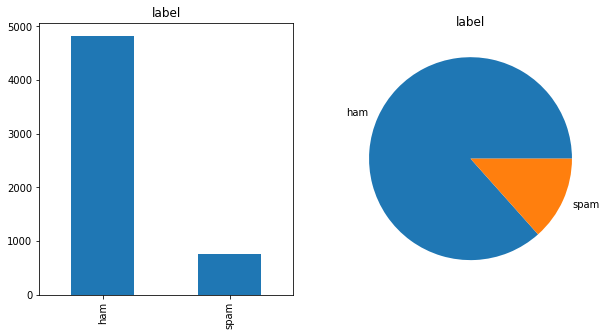

In [6]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
spam_df['label'].value_counts().plot(ax=ax[0], kind="bar", rot=90, title='label');
spam_df['label'].value_counts().plot(ax=ax[1], kind="pie", rot=90, title='label', ylabel='');
print("Dataset size: ", spam_df.shape)

spam_df.head(5)

In [7]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

import re  # 正则匹配

nltk.find('.')

FileSystemPathPointer('/home/jiqiboyi03/anaconda3/envs/py37/nltk_data')

In [8]:
stop_words = set(stopwords.words('english'))
non_words = list(punctuation)

In [9]:
stemmer = SnowballStemmer('english')

In [10]:
def stem_tokens(tokens, stemmer):
    stems = []
    for token in tokens:
        stems.append(stemmer.stem(token))
    return stems

**清除非英文词汇并替换数值x**

In [11]:
def clean_non_english_xdig(txt, isstem=True, gettok=True):
    txt = re.sub('[0-9]', 'x', txt)  # 去数字替换为x
    txt = txt.lower()  # 统一小写
    txt = re.sub('[^a-zA-Z]', ' ', txt)  # 去除非英文字符并替换为空格
    word_tokens = word_tokenize(txt)  # 分词
    if not isstem:  # 是否做词干还原
        filtered_word = [w for w in word_tokens if not w in stop_words]  # 删除停用词
    else:
        filtered_word = [stemmer.stem(w) for w in word_tokens if not w in stop_words]  # 删除停用词及词干还原
    if gettok:  # 返回为字符串或分词列表
        return filtered_word
    else:
        return " ".join(filtered_word)

**数据清洗**

In [13]:
spam_df['token'] = spam_df.message.apply(lambda x: clean_non_english_xdig(x))

**标签整数编码**

In [14]:
spam_df['label'] = (spam_df.label == 'spam').astype(int)

In [15]:
spam_df.head(3)

,label,message,token
0,0,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,0,Ok lar... Joking wif u oni...,"[ok, lar, joke, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entri, x, wkli, comp, win, fa, cup, fin..."


**训练词向量 Fasttext embed模型**

In [17]:
from gensim.models import FastText

In [20]:
model = FastText(spam_df.token,
                 vector_size=100,
                 sg=1,
                 window=3,
                 min_count=1,
                 epochs=10,
                 min_n=3,
                 max_n=6,
                 word_ngrams=1,
                 workers=12)

In [21]:
print("输出hello的词向量", model.wv['hello'])  # 词向量

输出hello的词向量 [ 0.05076134 -0.11662222 -0.01843588  0.11926778 -0.00692911 -0.23677106
  0.03265729  0.58572096 -0.00872138 -0.44825846  0.03305042 -0.26054367
 -0.34838268  0.31681454  0.06975181  0.08067543 -0.15547062 -0.06276258
 -0.3710448  -0.3126095  -0.40895212  0.04662197  0.5440838  -0.36142403
 -0.0353184  -0.19795361 -0.2943147   0.08752967 -0.16541521 -0.24446003
 -0.25770548 -0.07255884  0.8026316   0.05719731  0.00357276  0.18625565
  0.21387975  0.18544139 -0.19832784  0.1481844  -0.16753505 -0.34979635
 -0.15885958  0.02662933 -0.5794388  -0.44909018 -0.21648549 -0.0577201
  0.02627791  0.47935948  0.28716862 -0.18394181  0.10683677 -0.09927443
 -0.20707817 -0.23591241  0.41955677  0.1431753  -0.36858958  0.35350475
  0.38561156 -0.28347915 -0.20845327  0.13858971  0.28390867  0.3866409
  0.16182289  0.08862294 -0.02361779  0.37945366 -0.13112056  0.10072206
 -0.09405964 -0.35031617  0.3942728  -0.3285574   0.10972989 -0.28540993
 -0.35576847  0.17289421 -0.15837933  0.0

**对每个句子的所有词向量取均值，来生成一个句子的vector**

In [27]:
def build_sentence_vector(sentence, w2v_model, size=100):
    sen_vec = np.zeros((size,))
    count = 0
    for word in sentence:
        try:
            sen_vec += w2v_model.wv[word]  # .reshape((1,size))
            count += 1
        except KeyError:
            continue
    if count != 0:
        sen_vec /= count
    return sen_vec


**句向量**

In [28]:
sents_vec = []
for sent in spam_df['token']:
    sents_vec.append(build_sentence_vector(sent, model, size=100))

In [32]:
print(sents_vec[0])

[-6.64971950e-02 -8.11969709e-02  3.38522771e-02  1.28665774e-01
  3.49546479e-02 -2.14235565e-01  6.36148957e-02  4.10980064e-01
  1.02862138e-01 -3.74888418e-01  5.11251353e-02 -2.55440043e-01
 -2.48650149e-01  2.24217676e-01  4.23862389e-02  5.71289708e-02
 -9.86267962e-02 -1.46806023e-01 -3.07913865e-01 -2.13156764e-01
 -3.64509981e-01  5.61306984e-03  4.42305141e-01 -2.44850055e-01
  1.53577396e-02 -1.94223633e-01 -1.89313502e-01  4.89135414e-02
 -2.90020371e-01 -3.06456079e-01 -2.05873997e-01 -1.99328244e-02
  7.02249337e-01  6.73020110e-02  1.61267126e-01  8.36479440e-02
  1.98604750e-01  8.68831597e-02 -1.69676699e-01 -4.27024664e-02
 -1.99233853e-01 -3.00434729e-01 -4.58666682e-02 -5.17197893e-02
 -5.17031333e-01 -4.88360224e-01 -1.86615265e-01  6.79654069e-03
  5.99566244e-02  5.08627325e-01  3.10416128e-01 -3.88314097e-02
  1.90899348e-01 -3.42429212e-02 -2.98494641e-01 -2.27711794e-01
  4.33667582e-01  7.18952823e-02 -3.93282508e-01  3.50319101e-01
  4.07925014e-01 -2.74947

#### 训练文本分类模型

In [33]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

In [35]:
train_x, test_x, train_y, test_y = train_test_split(sents_vec, spam_df.label, test_size=0.2, shuffle=True,
                                                    random_state=42)

In [36]:
result = []
clf = LGBMClassifier(class_weight='balanced', n_estimators=300, num_leaves=64, reg_alpha=1, reg_lambda=1,
                     random_state=42)

In [37]:
clf.fit(train_x, train_y)

LGBMClassifier(class_weight='balanced', n_estimators=300, num_leaves=64,
               random_state=42, reg_alpha=1, reg_lambda=1)

In [38]:
from sklearn.metrics import auc, roc_curve, f1_score, precision_score, recall_score

In [39]:
def model_metrics(model, x, y, tp='auc'):
    """ 评估 """
    yhat = model.predict(x)
    yprob = model.predict_proba(x)[:, 1]
    fpr, tpr, _ = roc_curve(y, yprob, pos_label=1)
    metrics = {'AUC': auc(fpr, tpr), 'KS': max(tpr - fpr),
               'f1': f1_score(y, yhat), 'P': precision_score(y, yhat), 'R': recall_score(y, yhat)}

    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)

    plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    return metrics

train  {'AUC': 1.0, 'KS': 1.0, 'f1': 1.0, 'P': 1.0, 'R': 1.0}
test  {'AUC': 0.9909568221070812, 'KS': 0.9706735751295337, 'f1': 0.9636963696369638, 'P': 0.954248366013072, 'R': 0.9733333333333334}


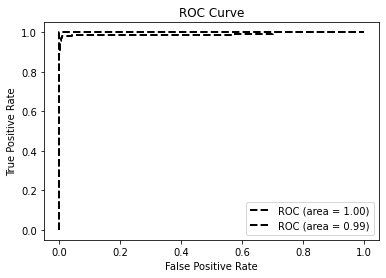

In [40]:
print('train ', model_metrics(clf, train_x, train_y, tp='ks'))
print('test ', model_metrics(clf, test_x, test_y, tp='ks'))